<a href="https://colab.research.google.com/github/11harini04/MDSProject/blob/master/Web_scraping_NSE_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install influxdb-client

In [0]:
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client import InfluxDBClient

#InfluxDB bucket and token for using InfluxDBClient
bucket = "Stocks"
org = "11harini04@gmail.com"
token = "A11NbY2ifqR8sQGdC8KUtXsmd-5gvFk8ruvlBzdyyFfDmb7bBRVzhoDf2_dOq5WL9J5EQBQpp2oL2vdGRCR8Uw=="
client = InfluxDBClient(url="https://us-west-2-1.aws.cloud2.influxdata.com",token=token)

In [0]:
import requests
import pandas as pd
from datetime import datetime
from bokeh.plotting import figure, show, output_file
from influxdb_client import Point

#API key to extract data from Yahoo Finance
API_KEY = 'GIJPOQVYSQTTJ319'

#Stock of Neyveli India Limited company
stock_name = 'NLCINDIA.BO'

#Scraping data from YahooFinance
r = requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=' + stock_name + '&apikey=' + API_KEY)
result = r.json()
dataForAllDays = result['Time Series (Daily)']

#convert to dataframe
df = pd.DataFrame.from_dict(dataForAllDays, orient='index') 

#rename columns
df = df.rename(index=str, columns={"index":"name", "1. open": "open", "2. high": "high", "3. low": "low", "4. close": "close","5. volume":"volume"})

#Changing the datatype 
df.open = df.open.astype(float)
df.close = df.close.astype(float)
df.high = df.high.astype(float)
df.low = df.low.astype(float)
df.volume = df.volume.astype(int)
name = [stock_name]*len(df)  
df['name'] = name
kind = 'Stock'

#Inserting into InfluxDB using InfluxdbClient
date = []
for ind in df.index:
  datetime_object = datetime.strptime(ind,'%Y-%m-%d')
  date.append(datetime_object)
  point = Point(kind).tag("name",df['name'][ind]).field("open",df['open'][ind]).field("close",df['close'][ind]).field("high",df['high'][ind]).field("low",df['low'][ind]).time(time = datetime_object)
  write_api = client.write_api(write_options = SYNCHRONOUS)
  write_api.write(bucket = bucket, org = org, record = point)
df['Date'] = date
df.set_index("Date", inplace = True) 

In [0]:
#Querying from InfluxDB and storing the results in Dataframe
df_copy = df
df = pd.DataFrame()
query = 'from(bucket: "Stocks") |> range(start: 2019-11-13, stop:2020-04-12)'
tables = client.query_api().query(query, org=org)
for table in tables:
  print(table)
  field_value = []
  for row in table.records:
    field_name = row.get_field()
    field_value.append(row.get_value())
  df[field_name] = field_value
df['Date'] = date
df.set_index("Date", inplace = True) 

FluxTable() columns: 9, records: 100
FluxTable() columns: 9, records: 100
FluxTable() columns: 9, records: 100
FluxTable() columns: 9, records: 100


In [0]:
df

,high,low,close,open
Date,,,,
2020-04-08,55.25,54.00,54.35,54.40
2020-04-07,54.75,54.20,54.25,54.50
2020-04-03,54.75,52.75,53.55,54.75
2020-04-01,54.00,53.10,53.40,53.35
2020-03-31,54.50,53.70,54.25,54.45
...,...,...,...,...
2019-11-20,44.40,43.15,44.00,43.15
2019-11-19,44.70,43.05,43.20,43.60
2019-11-18,44.05,42.80,43.60,43.60


In [0]:
!pip install pyramid-arima

In [0]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(df['close'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=368.763, BIC=381.093, Fit time=0.780 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=397.621, BIC=402.553, Fit time=0.035 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=375.254, BIC=385.118, Fit time=0.287 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=367.069, BIC=376.933, Fit time=0.399 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=368.721, BIC=381.051, Fit time=0.574 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=397.463, BIC=404.861, Fit time=0.085 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=368.718, BIC=381.047, Fit time=1.014 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=370.353, BIC=385.149, Fit time=3.582 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=365.980, BIC=373.377, Fit time=0.281 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 

In [0]:
stepwise_model_fit = stepwise_model.fit(df['close'])
forecast = stepwise_model_fit.predict(n_periods=10)

Text(0.5, 1.0, 'Forecasted plot of Closing price for next 10 days')

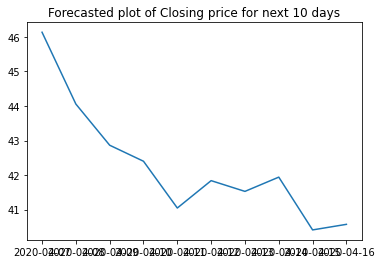

In [0]:
import matplotlib.pyplot as plt
dates = []
for i in range(7,17):
  s = '2020-04-'
  if(len(str(i))==1):
    s = s + '0' + str(i)
  else:
    s = s + str(i)
  dates.append(s)
plt.plot(dates,forecast)
plt.title('Forecasted plot of Closing price for next 10 days')

In [0]:
pip install --ignore-installed --upgrade keras

     |████████████████████████████████| 378kB 2.8MB/s 
     |████████████████████████████████| 2.9MB 11.9MB/s 
     |████████████████████████████████| 26.1MB 73.9MB/s 
     |████████████████████████████████| 20.2MB 146kB/s 
     |████████████████████████████████| 276kB 47.6MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=010cc9e86209df470e868f0843a2821e95ed040a7aead7fbd9e64e80b04bce9c
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built pyyaml
ERROR: qtconsole 4.7.2 has requirement pyzmq>=17.1, but you'll have pyzmq 17.0.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [2]:

#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt



/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


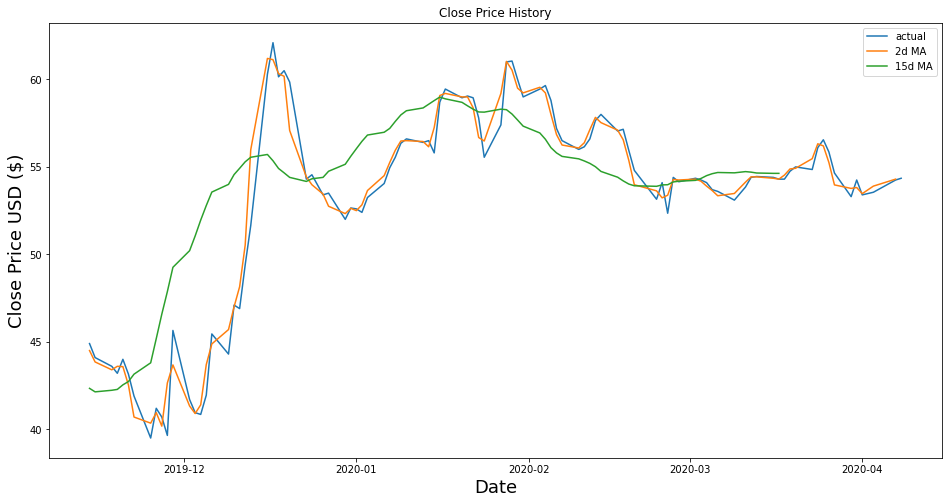

In [0]:
#Smoothing using Moving Averages to identify trends

#fast moving avg with q = 2days
df['2d'] = np.round(df['close'].rolling(window = 2, center = False).mean(), 2)

#df['10d'] = np.round(df['close'].rolling(window = 10, center = False).mean(), 2)

#slow moving avg with q = 15days
df['15d'] = np.round(df['close'].rolling(window = 15, center = False).mean(), 2)
plt.figure(figsize=(16,8))
plt.title('Close Price History')

#the closing price is plotted along moving averages
plt.plot(df['close'], label = 'actual')
plt.plot(df['2d'], label ='2d MA')
#plt.plot(df['10d'], label ='10d MA')
plt.plot(df['15d'], label ='15d MA')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
leg = plt.legend();
plt.show()


We can identify trends using this graph.

Fast moving MA, 2dMA is not affected by local changes.

From slow MA, 15d MA, we see there's 

*   a positive trend in the last two months of 2019   (bull market)
*   After the beginning of 2020, the market is slightly bearish, showing a negative trend (bear market)
 









In [0]:
df_1 = web.DataReader('NLCINDIA.BO', data_source='yahoo', start='2018-11-13', end='2020-04-12')

df_1

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-11-13,81.800003,80.150002,81.800003,80.800003,16375.0,67.196640
2018-11-14,82.400002,79.400002,81.849998,81.650002,42691.0,67.903534
2018-11-15,81.699997,81.300003,81.699997,81.599998,14262.0,67.861946
2018-11-16,81.750000,80.300003,81.750000,81.349998,15778.0,67.654037
2018-11-19,81.599998,80.500000,81.449997,81.400002,20093.0,67.695618
...,...,...,...,...,...,...
2020-04-01,44.700001,43.049999,43.599998,43.200001,21470.0,43.200001
2020-04-03,44.049999,42.799999,43.599998,43.599998,20121.0,43.599998
2020-04-07,45.000000,43.500000,43.500000,44.099998,18373.0,44.099998


In [0]:
data = df_1.filter(['Close'])

dataset = data.values

training_data_len = math.ceil( len(dataset) * .8 )

training_data_len

275

In [0]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.97983396],
       [1.        ],
       [0.99881369],
       [0.99288249],
       [0.9940688 ],
       [0.98695129],
       [0.9881376 ],
       [0.9632265 ],
       [0.99051005],
       [0.96441281],
       [0.88256217],
       [0.91103203],
       [0.96678526],
       [0.89798332],
       [0.98695129],
       [0.9632265 ],
       [0.93001176],
       [0.85053374],
       [0.71767494],
       [0.68090145],
       [0.70699886],
       [0.68683264],
       [0.68327407],
       [0.68327407],
       [0.67141167],
       [0.70106766],
       [0.68327407],
       [0.67615656],
       [0.66192172],
       [0.65361808],
       [0.65361808],
       [0.71648863],
       [0.7153025 ],
       [0.70818499],
       [0.68090145],
       [0.67734287],
       [0.678529  ],
       [0.68683264],
       [0.68801895],
       [0.68327407],
       [0.65836297],
       [0.66073541],
       [0.65954928],
       [0.66310785],
       [0.66903905],
       [0.67022536],
       [0.66903905],
       [0.677

In [0]:
#Create the training data set
train_data = scaled_data[0:training_data_len , :]


#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(30, len(train_data)):
  x_train.append(train_data[i-30:i, 0])
  y_train.append(train_data[i, 0])
  

In [0]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [0]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(245, 30, 1)

In [0]:

#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [0]:
model.fit(x_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
245/245 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 2/10
245/245 [==============================] - 0s 1ms/step - loss: 0.0041
Epoch 3/10
245/245 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 4/10
245/245 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 5/10
245/245 [==============================] - 0s 1ms/step - loss: 0.0039
Epoch 6/10
245/245 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 7/10
245/245 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 8/10
245/245 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 9/10
245/245 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 10/10
245/245 [==============================] - 0s 1ms/step - loss: 0.0038


In [0]:
test_data = scaled_data[training_data_len - 30: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(30, len(test_data)):
  x_test.append(test_data[i-30:i, 0])

In [0]:
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

#Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

#Get the root mean squared error (RMSE)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

4.393291185252077

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


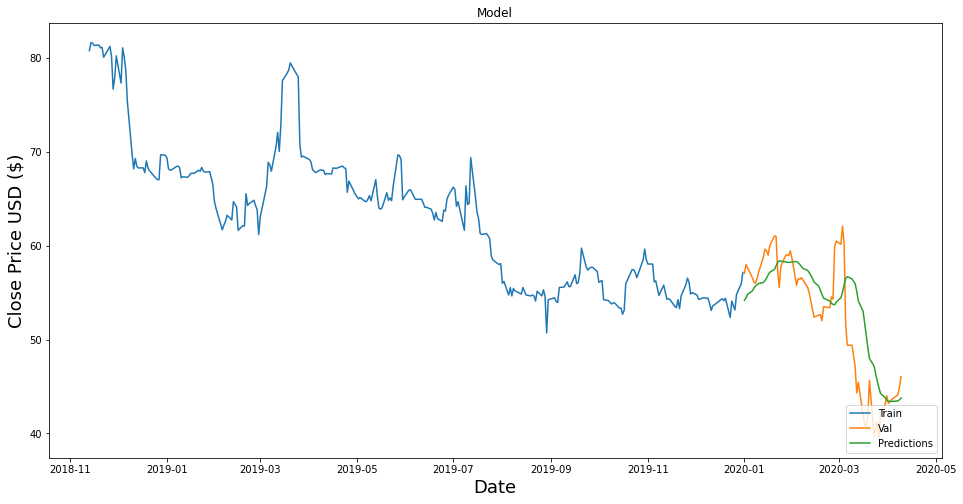

In [0]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [0]:
valid

,Close,Predictions
Date,,
2020-01-01,57.049999,55.161495
2020-01-02,58.000000,55.378361
2020-01-03,57.650002,55.655964
2020-01-06,56.599998,55.950294
2020-01-07,56.150002,56.203270
...,...,...
2020-04-01,43.200001,45.748360
2020-04-03,43.599998,45.658772
2020-04-07,44.099998,45.640575


In [3]:
df1 = pd.DataFrame()
df1['close'] = df['close']
df1['ticker'] = name

NameError: ignored

In [0]:
table = df1.pivot(columns='ticker')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()

In [0]:

stock_change = table.apply(lambda x: np.log(x) - np.log(x.shift(1)))

stock_change_apr = stock_change * 252 * 100    # There are 252 trading days in a year; the 100 converts to percentages
stock_change_apr.tail()

In [0]:
!pip install quandl

In [0]:
import quandl
import datetime
start = datetime.datetime(2019,11,13)
end = datetime.date.today()
quandl.ApiConfig.api_key = "7xNGEYrd8YUr2eT5feF-"
tbill = quandl.get("FRED/TB3MS")

The Sharpe ratio is another popular risk metric, defined below:

![alt text](https://cdn.wallstreetmojo.com/wp-content/uploads/2018/12/Sharpe-Ratio-Formula.jpg)

 We want the sharpe ratio to be large. A large Sharpe ratio indicates that the stock's excess returns are large relative to the stock's volatilitly. Additionally, the Sharpe ratio is tied to a statistical test (the t-test) to determine if a stock earns more on average than the risk-free rate; the larger this ratio, the more likely this is to be the case.

In [0]:
rrf = tbill.iloc[-1, 0]    # Get the most recent risk free rate
rrf

In [0]:
s = stock_change_apr.std()
x = stock_change_apr.mean() - rrf
sharpe = (x - rrf)/s
print("Sharpe ratio of NLCIndia Ltd. is",sharpe.values[0])